In [1]:
"""Script for optimization of a single topology"""
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import StarmapParallelization
from auto_robot_design.generator.restricted_generator.two_link_generator import TwoLinkGenerator, visualize_constrains

from auto_robot_design.optimization.saver import (
    ProblemSaver, )
from auto_robot_design.description.builder import jps_graph2pinocchio_robot
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import CalculateCriteriaProblemByWeigths, get_optimizing_joints, CalculateMultiCriteriaProblem, MultiCriteriaProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, ImfCompute, ManipCompute, MovmentSurface, NeutralPoseMass, TranslationErrorMSE, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.criterion_math import ImfProjections
from auto_robot_design.pinokla.default_traj import convert_x_y_to_6d_traj_xz, get_simple_spline, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory, get_horizontal_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningReward, PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, AccelerationCapability, MeanHeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import EndPointZRRReward, VelocityReward, ForceEllipsoidReward, ZRRReward, MinForceReward, MinManipulabilityReward
from auto_robot_design.optimization.rewards.inertia_rewards import MassReward
from auto_robot_design.description.actuators import TMotor_AK10_9, TMotor_AK60_6, TMotor_AK70_10, TMotor_AK80_64, TMotor_AK80_9
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L

In [2]:
import itertools
list(itertools.permutations([0,1,2]))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

{'Main_knee_2': (-0.30000000000000004, -0.1)}
[-0.3]


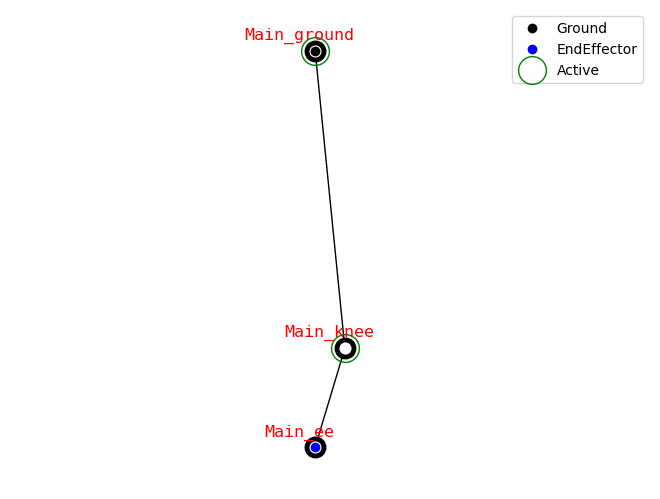

In [3]:
gm = GraphManager2L()
gm.reset()
gm.build_main(0.4, fully_actuated=True)
gm.set_mutation_ranges()
print(gm.mutation_ranges)
center = gm.generate_central_from_mutation_range()
center[0] = -0.3
print(center)
graph = gm.get_graph(center)
draw_joint_point(graph)

In [3]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [4]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))
# ground_symmetric_step = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
#     starting_point=[-0.1, -0.31], step_height=0.05, step_width=0.2, n_points=50))

ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50))


central_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.075, 0, 50))

left_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, -0.09, 50))

right_vertical = convert_x_y_to_6d_traj_xz(
    *get_vertical_trajectory(-0.32, 0.065, 0.09, 50))
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
    "POS_ERR": TranslationErrorMSE()  # MSE of deviation from the trajectory
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    # Impact mitigation factor along the axis
    "IMF": ImfCompute(ImfProjections.Z),
    "MANIP": ManipCompute(MovmentSurface.XZ),
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

# set the rewards and weights for the optimization task
acceleration_capability = MinAccelerationCapability(manipulability_key='Manip_Jacobian',
                                                    trajectory_key="traj_6d", error_key="error", actuated_mass_key="Actuated_Mass")
min_velocity = MinManipulabilityReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

min_force = MinForceReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")
heavy_lifting = HeavyLiftingReward(
    manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error", mass_key="MASS")

# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
soft_constrain = PositioningConstrain(
    error_calculator=error_calculator, points=[workspace_trajectory])


# manager should be filled with trajectories and rewards using the manager API
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_trajectory(ground_symmetric_step2, 1)
reward_manager.add_trajectory(ground_symmetric_step3, 2)

reward_manager.add_trajectory(central_vertical, 3)
reward_manager.add_trajectory(left_vertical, 4)
reward_manager.add_trajectory(right_vertical, 5)

reward_manager.add_reward(acceleration_capability, 0, 1)
reward_manager.add_reward(acceleration_capability, 1, 1)
reward_manager.add_reward(acceleration_capability, 2, 1)


reward_manager.add_reward(heavy_lifting, 3, 1)
reward_manager.add_reward(heavy_lifting, 4, 1)
reward_manager.add_reward(heavy_lifting, 5, 1)

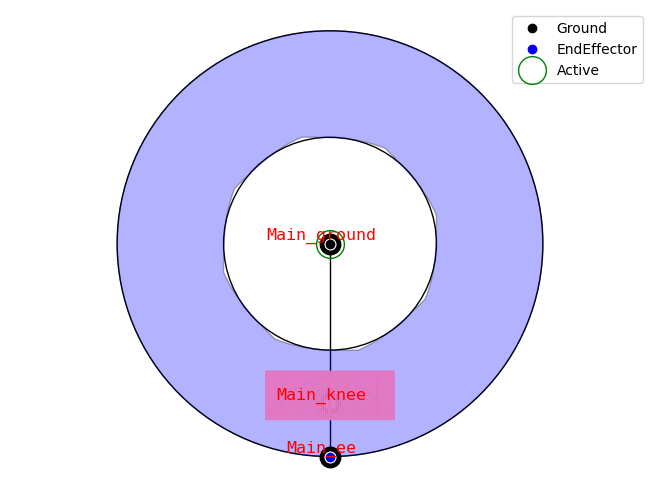

In [5]:
from matplotlib.patches import Circle, PathPatch
from matplotlib.path import Path
draw_joint_point(graph)
# Parameters for the circles
center = (0, 0)
radius1 = 0.4
radius2 = 0.2

# Create a figure and axis
ax = plt.gca()

# Define the outer and inner circles
outer_circle = Circle(center, radius1, edgecolor='black', facecolor='none')
inner_circle = Circle(center, radius2, edgecolor='black', facecolor='none')

# Add circles to the plot
ax.add_patch(outer_circle)
ax.add_patch(inner_circle)

# Create the paths for the circles
outer_path = Path.circle(center=center, radius=radius1)
inner_path = Path.circle(center=center, radius=radius2)

# Create the path patch for the area between the circles
vertices = np.concatenate([outer_path.vertices, inner_path.vertices[::-1]])
codes = np.concatenate([outer_path.codes, inner_path.codes])
path = Path(vertices, codes)
patch = PathPatch(path, facecolor='blue', alpha=0.3)

# Add the path patch to the plot
ax.add_patch(patch)
for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

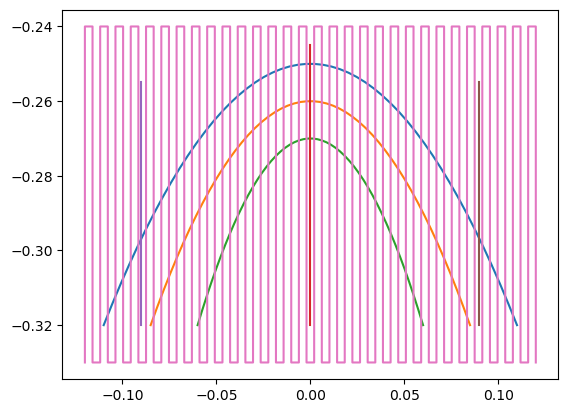

In [6]:


for _, trajectory in reward_manager.trajectories.items():
    plt.plot(trajectory[:, 0], trajectory[:, 2])

plt.plot(workspace_trajectory[:, 0], workspace_trajectory[:, 2])
plt.show()

In [80]:
# activate multiprocessing
N_PROCESS = 8
pool = multiprocessing.Pool(N_PROCESS)
runner = StarmapParallelization(pool.starmap)

In [81]:
from pymoo.algorithms.moo.age2 import AGEMOEA2

population_size = 32
n_generations = 10

# create the problem for the current optimization
problem = MultiCriteriaProblem(gm, builder, reward_manager,
                               soft_constrain, elementwise_runner=runner, Actuator=actuator)

saver = ProblemSaver(problem, "test", True)
saver.save_nonmutable()
algorithm = AGEMOEA2(pop_size=population_size, save_history=True)
optimizer = PymooOptimizer(problem, algorithm, saver)

res = optimizer.run(
    True, **{
        "seed": 3,
        "termination": ("n_gen", n_generations),
        "verbose": True
    })

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       32 |     31 |             - |             -
     2 |       64 |     32 |  0.0106878141 |         ideal
     3 |       96 |     32 |  0.0403196974 |         ideal
     4 |      128 |     32 |  0.0277852106 |         ideal
     5 |      160 |     32 |  0.0099870251 |         ideal
     6 |      192 |     32 |  0.0104278706 |         ideal
     7 |      224 |     32 |  0.0214798735 |             f
     8 |      256 |     32 |  0.0212236252 |         ideal
     9 |      288 |     32 |  0.0026158488 |         nadir
    10 |      320 |     32 |  0.0027935955 |             f


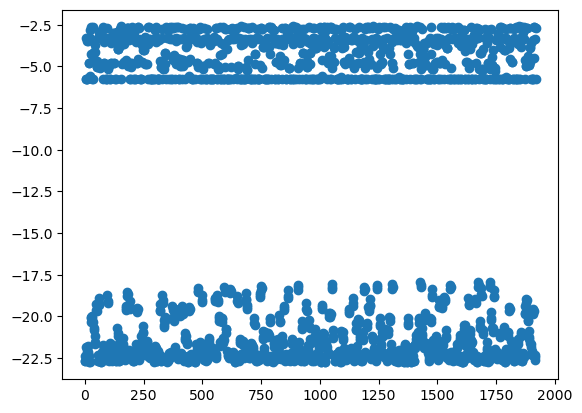

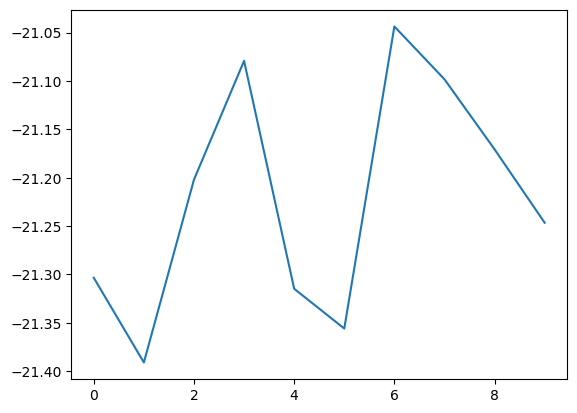

In [82]:
flatten_history = np.array(optimizer.history["F"]).flatten()
history_mean = np.array(optimizer.history["Mean"])
plt.scatter(np.arange(len(flatten_history)), flatten_history)
plt.show()
plt.plot(np.arange(len(history_mean)), history_mean[:, 0])
plt.show()


In [83]:
flatten_history

array([-22.37596762, -22.68762711, -22.66469905, ...,  -3.32763389,
        -2.69170304,  -5.75977046])

In [84]:
history_mean

array([[-21.30342258, -21.61527278, -21.61710112,  -3.73542413,
         -4.07464584,  -4.58478643],
       [-21.39100997, -21.69374699, -21.64943823,  -3.70527508,
         -4.04970237,  -4.86472866],
       [-21.20201085, -21.50165009, -21.46796282,  -3.78863681,
         -4.24433616,  -4.81334716],
       [-21.07919626, -21.36243488, -21.27011681,  -3.84047322,
         -4.28317055,  -4.9730791 ],
       [-21.31480683, -21.61737182, -21.57365248,  -3.7333956 ,
         -4.16633415,  -4.73051872],
       [-21.35594069, -21.64690191, -21.58653208,  -3.71100893,
         -4.16620121,  -4.65174572],
       [-21.04366422, -21.33425039, -21.26353193,  -3.84316231,
         -4.16034655,  -4.96614261],
       [-21.09825686, -21.39454709, -21.3523283 ,  -3.82574505,
         -4.16779989,  -4.84006573],
       [-21.17068811, -21.46756305, -21.404941  ,  -3.79914424,
         -4.43082805,  -4.43549544],
       [-21.24657101, -21.53751679, -21.4756126 ,  -3.76462011,
         -4.09021414,  -4.8

Scale f1: [-22.41399534951467, -17.947924188429756]
Scale f2: [-22.734225758115034, -18.231784377049745]


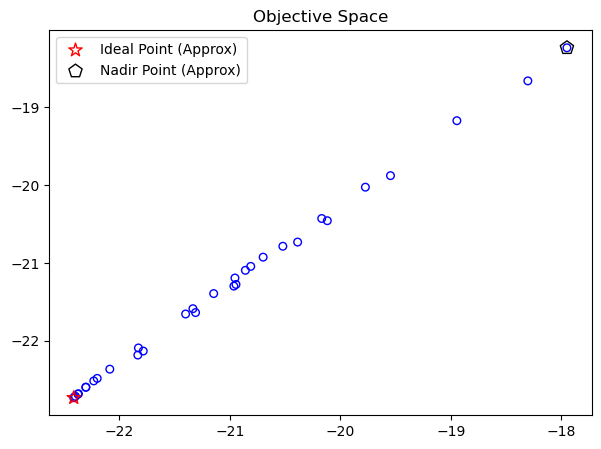

In [85]:
F = res.F
fl = F.min(axis=0)
fu = F.max(axis=0)
print(f"Scale f1: [{fl[0]}, {fu[0]}]")
print(f"Scale f2: [{fl[1]}, {fu[1]}]")
approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
plt.figure(figsize=(7, 5))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.scatter(approx_ideal[0], approx_ideal[1], facecolors='none',
            edgecolors='red', marker="*", s=100, label="Ideal Point (Approx)")
plt.scatter(approx_nadir[0], approx_nadir[1], facecolors='none',
            edgecolors='black', marker="p", s=100, label="Nadir Point (Approx)")
plt.title("Objective Space")
plt.legend()
plt.show()